In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
from torchvision import datasets
datasets.MNIST.resources = [
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
        ]

In [3]:
transform = transforms.ToTensor()

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
dataiter = iter(dataloader)
images,labels = dataiter.next()
print(torch.min(images),torch.max(images))

tensor(0.) tensor(1.)


In [5]:
class autoencoderCon(nn.Module):
  def __init__(self):
    super().__init__()
    #N,1,28,28
    self.encoder = nn.Sequential(
        nn.Conv2d(1,16,3,stride=1,padding=1), #N,16,14,14
        nn.MaxPool2d(2,2),
        nn.ReLU(),
        nn.Conv2d(16,8,3,stride=1,padding=1), #N,32,7,7
        nn.MaxPool2d(2,2),
        nn.ReLU(),
        nn.Conv2d(8,8,4) #N,64,1,1
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(8,8,4), #N,32,7,7
        nn.ReLU(),
        #nn.ConvTranspose2d(8,16,3), #N,16,13,13
        nn.ConvTranspose2d(8,16,3,stride=2,padding=1,output_padding=1), #N,16,14,14
        nn.ReLU(),
        nn.ConvTranspose2d(16,1,3,stride=2,padding=1,output_padding=1), #N,1,28,28
        nn.Sigmoid()
    )
    
  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

model = autoencoderCon()
print(model)

autoencoderCon(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(8, 8, kernel_size=(4, 4), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [6]:
from torchsummary import summary
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
              ReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]           1,160
         MaxPool2d-5              [-1, 8, 7, 7]               0
              ReLU-6              [-1, 8, 7, 7]               0
            Conv2d-7              [-1, 8, 4, 4]           1,032
   ConvTranspose2d-8              [-1, 8, 7, 7]           1,032
              ReLU-9              [-1, 8, 7, 7]               0
  ConvTranspose2d-10           [-1, 16, 14, 14]           1,168
             ReLU-11           [-1, 16, 14, 14]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]             145
          Sigmoid-13            [-1, 1, 28, 28]               0
Total params: 4,697
Trainable params: 4

In [7]:
model = autoencoderCon()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

In [8]:
n_epoch = 20
outputs = []
for epoch in range(1, n_epoch+1):
  for(image,label) in dataloader:
    #image = image.reshape(-1,28*28)
    output_img = model(image)
    loss = criterion(output_img,image)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,loss))
  outputs.append((epoch, image, output_img))




Epoch: 1 	Training Loss: 0.015582
Epoch: 2 	Training Loss: 0.010677
Epoch: 3 	Training Loss: 0.009248
Epoch: 4 	Training Loss: 0.008447
Epoch: 5 	Training Loss: 0.007957
Epoch: 6 	Training Loss: 0.007767
Epoch: 7 	Training Loss: 0.007548
Epoch: 8 	Training Loss: 0.007196
Epoch: 9 	Training Loss: 0.006923
Epoch: 10 	Training Loss: 0.006764
Epoch: 11 	Training Loss: 0.006619
Epoch: 12 	Training Loss: 0.006494
Epoch: 13 	Training Loss: 0.006389
Epoch: 14 	Training Loss: 0.006282
Epoch: 15 	Training Loss: 0.006190
Epoch: 16 	Training Loss: 0.006123
Epoch: 17 	Training Loss: 0.006059
Epoch: 18 	Training Loss: 0.005982
Epoch: 19 	Training Loss: 0.005891
Epoch: 20 	Training Loss: 0.005821


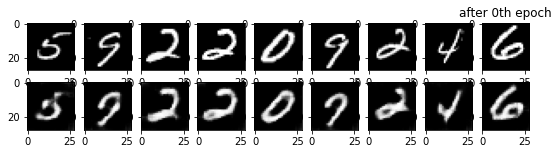

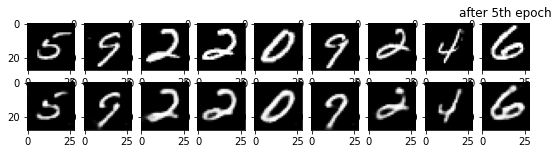

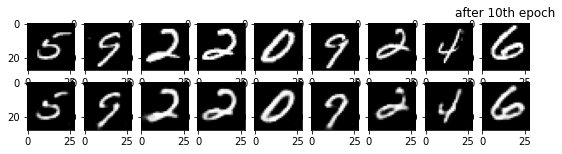

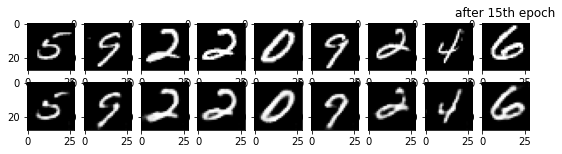

In [16]:
for k in range(0,n_epoch,5):
  plt.figure(figsize=(9,2))
  plt.gray()
  #print(k)
  imgs = outputs[k][1].detach().numpy()
  recons = outputs[k][2].detach().numpy()

  for i,item in enumerate(imgs):
    if i>=9: break
    plt.subplot(2,9,i+1)
    #item = item.reshape(-1,28,28)
    plt.imshow(item[0])
  plt.title("after "+ str(k)+ "th epoch")

  for i,item in enumerate(recons):
    if i>=9: break
    plt.subplot(2,9,9+i+1)
    #item = item.reshape(-1,28,28)
    plt.imshow(item[0])
